In [61]:
import os
import xmltodict
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [41]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [26]:
# Set the path to your image folder
image_folder_path = "/Users/sumaiyauddin/Documents/Semester03/CCNY-DSE-Capstone-Project-Segmenting-Coral-Branch-tips/data/external/Coral_images"

img_names = [] 
xml_names = []

# Walk through the image folder to collect image and XML file names
for dirname, _, filenames in os.walk(image_folder_path):
    for filename in filenames:
        if filename.endswith('.jpg'):
            img_names.append(filename)
        elif filename.endswith('.xml'):
            xml_names.append(filename)


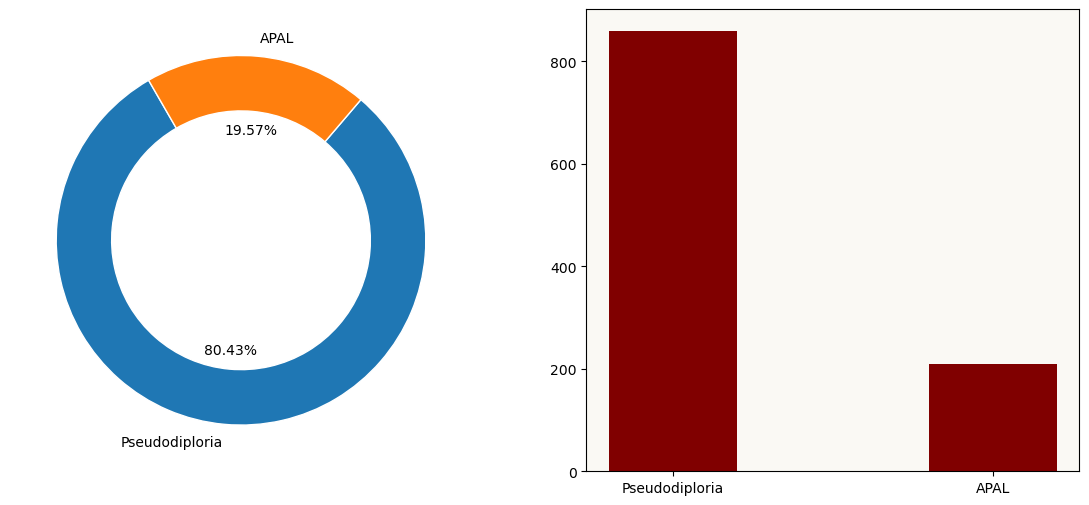

In [27]:
path_annotations = "/Users/sumaiyauddin/Documents/Semester03/CCNY-DSE-Capstone-Project-Segmenting-Coral-Branch-tips/data/external/Coral_images/annotation/"

listing = []

for img_name in img_names:
    # Generate the XML file path based on the image file name
    xml_path = os.path.join(path_annotations, img_name[:-4] + ".xml")
    
    if os.path.exists(xml_path):
        with open(xml_path) as fd:
            doc = xmltodict.parse(fd.read())
        temp = doc["annotation"]["object"]
        if isinstance(temp, list):
            for obj in temp:
                listing.append(obj["name"])
        else:
            listing.append(temp["name"])
    else:
        print(f"XML file not found for image: {img_name}")

# Count the occurrences of object names in the XML files
Items = Counter(listing).keys()
values = Counter(listing).values()

# Plot the data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
background_color = '#faf9f4'
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color) 
ax1.pie(values, wedgeprops=dict(width=0.3, edgecolor='w'),
        labels=Items, radius=1, startangle=120, autopct='%1.2f%%')

ax2 = plt.bar(Items, list(values),
              color='maroon', width=0.4)

plt.show()

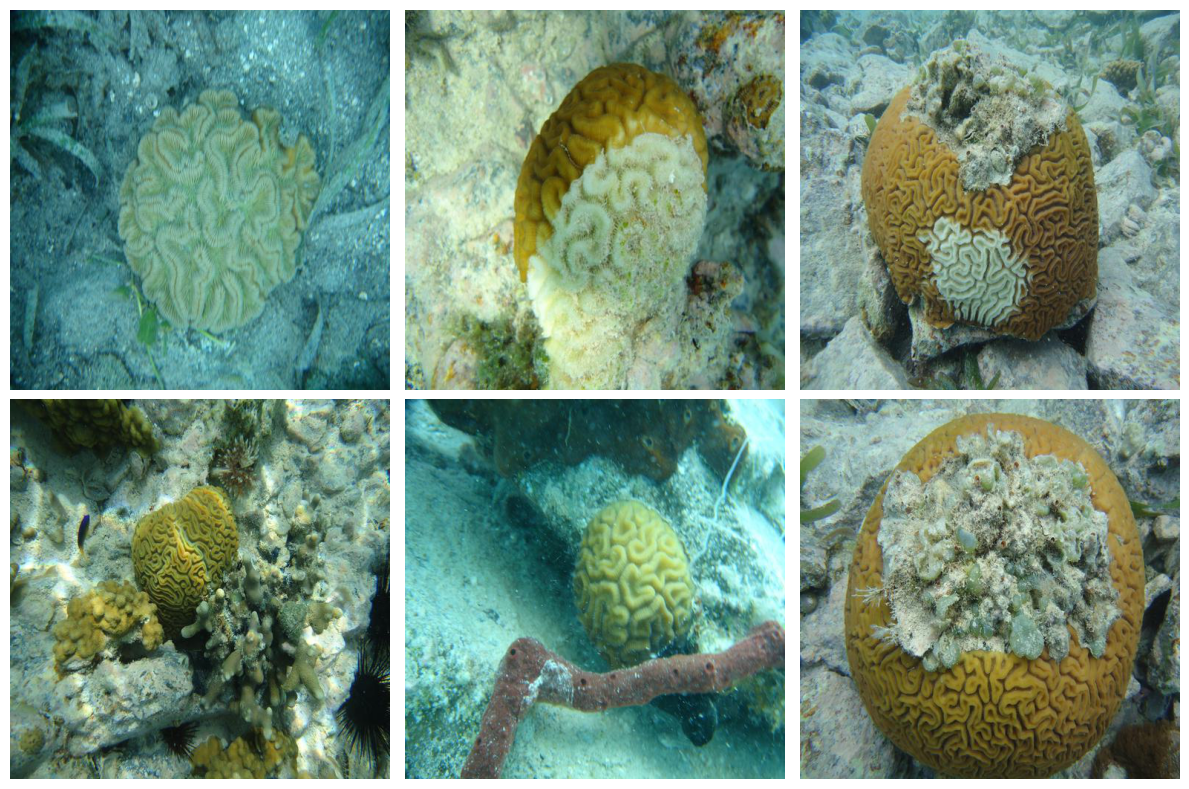

In [34]:
# Set the paths to your image and annotation folders
path_image = "/Users/sumaiyauddin/Documents/Semester03/CCNY-DSE-Capstone-Project-Segmenting-Coral-Branch-tips/data/external/Coral_images/image"
path_annotations = "/Users/sumaiyauddin/Documents/Semester03/CCNY-DSE-Capstone-Project-Segmenting-Coral-Branch-tips/data/external/Coral_images/annotation/"

# Get a list of image filenames from the image folder
img_names = [filename for filename in os.listdir(path_image) if filename.lower().endswith('.jpg')]

# Create a 3x2 subplot grid
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.ravel()  # Flatten the 3x2 grid

def corals(img, ax):
    # Generate the corresponding XML filename by changing the extension to ".xml"
    xml_file = os.path.splitext(img)[0] + ".xml"
    xml_path = os.path.join(path_annotations, xml_file)

    if os.path.exists(xml_path):
        with open(xml_path) as fd:
            doc = xmltodict.parse(fd.read())

        image = plt.imread(os.path.join(path_image, img))

        temp = doc["annotation"]["object"]

        if isinstance(temp, list):
            for i in range(len(temp)):
                if "bndbox" in temp[i]:
                    x, y, w, h = list(map(int, temp[i]["bndbox"].values()))
                    name = temp[i]["name"]
                    edgecolor = {"APAL": "g", "Pseudodiploria": "r"}
                    mpatch = mpatches.Rectangle((x, y), w - x, h - y, linewidth=1, edgecolor=edgecolor.get(name, 'b'), facecolor="none", lw=2)
                    ax.add_patch(mpatch)
                    rx, ry = mpatch.get_xy()
                    ax.annotate(name, (rx, ry), color=edgecolor.get(name, 'b'), weight='bold', fontsize=10, ha='left', va='baseline')

        ax.imshow(image)

# Display images with bounding boxes in the subplot grid
for i, img in enumerate(img_names[:6]):
    corals(img, axs[i])
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [54]:
# Set the paths to your image and annotation folders
path_image = "/Users/sumaiyauddin/Documents/Semester03/CCNY-DSE-Capstone-Project-Segmenting-Coral-Branch-tips/data/external/Coral_images/image"
path_annotations = "/Users/sumaiyauddin/Documents/Semester03/CCNY-DSE-Capstone-Project-Segmenting-Coral-Branch-tips/data/external/Coral_images/annotation/"

# Define options for labels
options = {"APAL": 0, "Pseudodiploria": 1}

# Define your transformation
my_transform = transforms.Compose([transforms.Resize((512, 512)), transforms.ToTensor()])

def dataset_creation(image_list):
    image_tensor = []
    label_tensor = []
    
    for i, j in enumerate(image_list):
        with open(os.path.join(path_annotations, j[:-4] + ".xml")) as fd:
            doc = xmltodict.parse(fd.read())
        
        if isinstance(doc["annotation"]["object"], list):
            temp = doc["annotation"]["object"]
            for k in range(len(temp)):
                x, y, w, h = list(map(int, temp[k]["bndbox"].values()))
                label = options.get(temp[k]["name"], -1)  # Get label, or use -1 if not found
                image = transforms.functional.crop(Image.open(os.path.join(path_image, j)).convert("RGB"), y, x, h - y, w - x)
                image_tensor.append(my_transform(image))
                label_tensor.append(torch.tensor(label))
        else:
            temp = doc["annotation"]["object"]
            x, y, w, h = list(map(int, temp["bndbox"].values()))
            label = options.get(temp["name"], -1)  # Get label, or use -1 if not found
            image = transforms.functional.crop(Image.open(os.path.join(path_image, j)).convert("RGB"), y, x, h - y, w - x)
            image_tensor.append(my_transform(image))
            label_tensor.append(torch.tensor(label))
    
    final_dataset = [[k, l] for k, l in zip(image_tensor, label_tensor)]
    return final_dataset

# Create the dataset
mydataset = dataset_creation(img_names)


In [55]:
mydataset[0]

[tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor(1)]

In [63]:
# Split the dataset into training and testing sets
train_dataset, test_dataset = train_test_split(mydataset, test_size=0.2, random_state=42)
print(f"Number of samples in the training set: {len(train_dataset)}")
print(f"Number of samples in the test set: {len(test_dataset)}")


Number of samples in the training set: 854
Number of samples in the test set: 214


In [64]:
# Assuming you have created DataLoader instances for your train and test datasets
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# The batch size is set to 64, you can adjust it based on your needs.

# Check the size of the training data batches
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


Feature batch shape: torch.Size([64, 3, 512, 512])
Labels batch shape: torch.Size([64])


/var/folders/ph/_s861md14q5c2ykky6q5pgd80000gn/T/ipykernel_11817/2640185228.py:18: RuntimeWarning: invalid value encountered in divide
  image = (image - min_val) / (max_val - min_val)


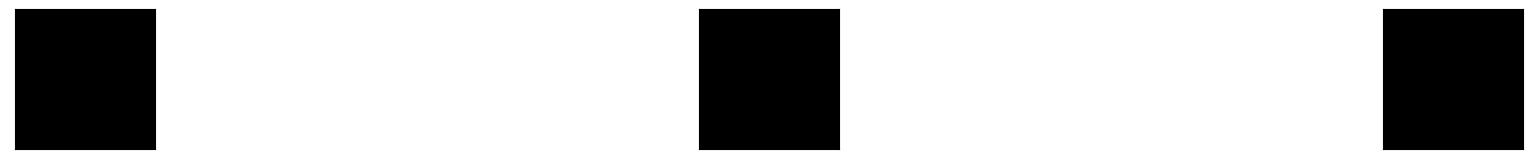

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have train_features as a PyTorch tensor
train_features_np = train_features.numpy()

# Create a figure for visualization
fig = plt.figure(figsize=(25, 4))

# Visualize the first few images (adjust the number of images as needed)
for idx in range(3):
    ax = fig.add_subplot(2, 3, idx + 1, xticks=[], yticks=[])
    
    # Adjust the channel order and normalize the image
    image = train_features_np[idx].transpose(1, 2, 0)
    min_val = np.min(image)
    max_val = np.max(image)
    image = (image - min_val) / (max_val - min_val)
    
    plt.imshow(image)
    
plt.show()
